In [5]:
import os
import sys
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plot_library import Line, set_ax_design, plot_matplotlib, sort_names, give_time, interpolate_by_ngb, signal_filtering
print(sys.version)
sys.path.append(os.path.join(os.getcwd(), "../tube"))

rc_params = {
    'backend': 'pdf',
    'font.size': 9,
    'axes.labelsize': 9,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'lines.linewidth': 1,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath}',
    "font.family": "serif",
    'figure.figsize': [32/5.33333 - 2*0.416667, 3]
}
matplotlib.rcParams.update(rc_params)
data_theory_all = dict()
data_r_sol_all = dict()

3.10.14 (main, Mar 19 2024, 21:46:16) [Clang 15.0.0 (clang-1500.3.9.4)]


In [6]:
path = "../Heat_transfer_Polymerization/Verif"
# data_name = "/cylinder_polymerization_basilisk_nmax=10.csv"
# data_name = "/cylinder_polymerization_basilisk.csv"
# data_name = "/cylinder_polymerization_basilisk_A_0.csv"
data_name = "/cylinder_polymerization_basilisk_A_0_noext.csv"

data_all = {
    "A=0": pd.read_csv(f"{path}/cylinder_polymerization_basilisk_A_0.csv", header=0),
    "A=0_no_extrapolation": pd.read_csv(f"{path}/cylinder_polymerization_basilisk_A_0_noext.csv", header=0),
    "Aneq0": pd.read_csv(f"{path}/cylinder_polymerization_basilisk_Aneq0.csv", header=0),
    "Aneq0_no_extrapolation": pd.read_csv(f"{path}/cylinder_polymerization_basilisk_Aneq0_noext.csv", header=0),
    "couette_A=0": pd.read_csv(f"{path}/couette_polymerization_basiliskA_0_couette.csv", header=0),
    "couette_A=0_different_T": pd.read_csv(f"{path}/couette_polymerization_basiliskA_0_different_T.csv", header=0),
    "couette_Aneq0": pd.read_csv(f"{path}/couette_polymerization_basiliskAneq0_couette.csv", header=0),
    "couette_Aneq0_different_T": pd.read_csv(f"{path}/couette_polymerization_basiliskAneq0_different_T.csv", header=0),
}

# local1 = "/cylinder_polymerization_basilisk_A_0_local.csv"
# local2 = "/cylinder_polymerization_basilisk_A_0.csv"
# data_all = {
#     "A=0": pd.read_csv(f"{path}{local2}", header=0),
#     "A=0_no_extrapolation": pd.read_csv(f"{path}{local1}", header=0),
#     "Aneq0": pd.read_csv(f"{path}{local2}", header=0),
#     "Aneq0_no_extrapolation": pd.read_csv(f"{path}{local1}", header=0),
# }
def polym(x: float | None, t: float | None, maxlevel: int, field: str, name: str) -> float | np.ndarray:
    data = data_all[name]
    if x != None and t != None:
        return data[(data["x"]==x) & (data["t"]==t) & (data["maxlevel"]==maxlevel)][field].values[0]
    if x != None:
        return data[(data["x"]==x) & (data["maxlevel"]==maxlevel)][field].values
    if t != None:
        return data[(data["t"]==t) & (data["maxlevel"]==maxlevel)][field].values
    return 0

def polym_xty(
    x: float | None,
    t: float | None,
    maxlevel: int,
    field: str, 
    name: str
) -> tuple[float, float, float] | tuple[np.ndarray, np.ndarray, np.ndarray]:
    data = data_all[name]
    if x != None and t != None:
        filtered_data = data[(data["x"]==x) & (data["t"]==t) & (data["maxlevel"]==maxlevel)]
        return x, t, filtered_data[field].values[0]
    if x != None:
        filtered_data = data[(data["x"]==x) & (data["maxlevel"]==maxlevel)]
        return x, filtered_data["t"], filtered_data[field].values
    if t != None:
        filtered_data = data[(data["t"]==t) & (data["maxlevel"]==maxlevel)]
        return filtered_data["x"], t, filtered_data[field].values
    return 0

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

def heat_transfer_polymerization_cylinder(nump, props, bc_ic):
    
    r = np.linspace(nump["r_min"], nump["r_max"], nump["r_points"])
    
    # Initial conditions
    T0 = bc_ic["T0_fun"](r)  # T(r, t=0) = 1
    alpha0 = bc_ic["alpha0"] * np.ones(nump["r_points"])  # alpha(r, t=0) = 0

    # Boundary conditions
    T0[0] = bc_ic["T_solid"]  # T(r=1, t) = T_solid
    
    # Function to compute dT/dt and dalpha/dt
    def odes(t, y, r):
        T, alpha = np.split(y, 2)
        alpha = np.clip(alpha, 0, 1)

        # dalpha/dt equation
        dalphadt = props["A"] * (1 - alpha)**props["n"] * np.exp(-props["Ea"] / (props["R"] * T))
        
        # Compute spatial derivatives for T
        dTdr = np.gradient(T, r, edge_order=2)
        
        # Apply boundary conditions at r_max
        dTdr[-1] = 0
        d2Tdr2 = np.gradient(dTdr, r, edge_order=2)
        
        # dT/dt equation
        dTdt = (props["kappa"] * (d2Tdr2 + (1/r) * dTdr) + props["H"] * props["rho"] * dalphadt) / (props["rho"] * props["Cp"])
        
        # Apply boundary conditions
        dTdt[0] = bc_ic["dTdt_solid"]  # T(r=1, t) is fixed, hence its derivative should be 0
        
        return np.concatenate([dTdt, dalphadt])
    
    # Initial conditions concatenated
    y0 = np.concatenate([T0, alpha0])
    
    # Solve the system using solve_ivp
    args = (r,)
    sol = solve_ivp(fun=odes, t_span=[nump["t_min"], nump["t_max"]], y0=y0, args=args, method=nump["method"], rtol=1e-10, atol=1e-12, dense_output=True)
    return sol, args

def heat_transfer_polymerization_cylinder_solution(sol, r, t_fix=None, r_fix=None) -> dict:
    y_new = sol.sol(t_fix)
    T_sol, alpha_sol = np.split(y_new, 2)
    if r_fix:
        # fit the interpolation on the original index and values
        f_T = interp1d(r, T_sol, kind='linear')
        f_alpha = interp1d(r, alpha_sol, kind='linear')
        return {"T": f_T(r_fix), "alpha": f_alpha(t_fix)}
    return {"T": T_sol, "alpha": alpha_sol}

def heat_transfer_polymerization_couette(nump, props, bc_ic):
    
    y = np.linspace(nump["y_min"], nump["y_max"], nump["r_points"])
    
    # Initial conditions
    T0 = bc_ic["T0_fun"](y)  # T(y, t=0) = 1
    alpha0 = bc_ic["alpha0"] * np.ones(nump["r_points"])  # alpha(y, t=0) = 0
    U0 = bc_ic["U0_fun"](y)

    # Boundary conditions
    T0[0] = bc_ic["T_bottom"]  # T(r=-0.5, t) = T_bottom
    T0[-1] = bc_ic["T_top"]  # T(r=0.5, t) = T_top
    U0[0] = bc_ic["U_bottom"]
    U0[-1] = bc_ic["U_top"]
    
    # Function to compute dT/dt and dalpha/dt
    def odes(t, rhs, y):
        T, alpha, u = np.split(rhs, 3)
        alpha = np.clip(alpha, 0, 1)

        # dalpha/dt equation
        dalphadt = props["A"] * (1 - alpha)**props["n"] * np.exp(-props["Ea"] / (props["R"] * T))
        
        # Compute spatial derivatives for T
        dTdy = np.gradient(T, y, edge_order=2)
        
        # Compute the second spatial derivatives for T
        d2Tdy2 = np.gradient(dTdy, y, edge_order=2)
        
        # dT/dt equation
        dTdt = (props["kappa"] * d2Tdy2 + props["H"] * props["rho"] * dalphadt) / (props["rho"] * props["Cp"])
        
        # Apply boundary conditions
        dTdt[0] = bc_ic["dTdt_solid"]  # T(r=1, t) is fixed, hence its derivative should be 0
        dTdt[-1] = bc_ic["dTdt_solid"]

        # du/dt equation
        dudy = np.gradient(u, y, edge_order=2)
        mu = props["mu_fun"](T, alpha)
        d2udy2 = np.gradient(mu*dudy, y, edge_order=2)
        dudt = d2udy2/props["rho"]
        
        return np.concatenate([dTdt, dalphadt, dudt])
    
    # Initial conditions concatenated
    y0 = np.concatenate([T0, alpha0, U0])
    
    # Solve the system using solve_ivp
    args = (y,)
    sol = solve_ivp(fun=odes, t_span=[nump["t_min"], nump["t_max"]], y0=y0, args=args, method=nump["method"], rtol=1e-10, atol=1e-12, dense_output=True)
    return sol, args

def heat_transfer_polymerization_couette_solution(sol, y, t_fix=None, y_fix=None) -> dict:
    y_new = sol.sol(t_fix)
    T_sol, alpha_sol, u_sol = np.split(y_new, 3)
    if y_fix:
        # fit the interpolation on the original index and values
        f_T = interp1d(y, T_sol, kind='linear')
        f_alpha = interp1d(y, alpha_sol, kind='linear')
        f_u = interp1d(y, u_sol, kind='linear')
        return {"T": f_T(r_fix), "alpha": f_alpha(t_fix), "u": f_u(t_fix)}
    return {"T": T_sol, "alpha": alpha_sol, "u": u_sol}

In [8]:
def compute_error(
    x: np.ndarray, 
    y: np.ndarray, 
    x_theory: np.ndarray, 
    y_theory: np.ndarray, 
    norm_type: str, 
    kind: str = "linear", 
    N: int = 1000,
) -> float:
    if isinstance(x, float):
        x_min = x
        x_max = x
        xx = x
        yy = y
        yy_theory = y_theory
        return np.abs(yy - yy_theory)
    else:
        x_min = max(x.min(), x_theory.min())
        x_max = min(x.max(), x_theory.max())
        # x_min = 2
        xx = np.linspace(x_min, x_max, N)
        f = interp1d(x, y, kind=kind)
        yy = f(xx)
        f_theory = interp1d(x_theory, y_theory, kind=kind)
        yy_theory = f_theory(xx)
    # Compute the difference
    difference = np.abs(yy - yy_theory)

    if norm_type == 'L2':
        # return np.sqrt(np.sum(difference**2) * (xx[1] - xx[0]))
        # # L2 norm: sqrt(sum(diff^2 * dx))
        dx = np.diff(xx)  # Compute differences between consecutive x values
        return np.sqrt(np.sum(difference[:-1]**2 * dx))  # Integrate with dx (non-uniform spacing)
    elif norm_type == 'Linf':
        # Linf norm: max(abs(diff))
        return np.max(np.abs(difference))  # Maximum absolute difference
    else:
        raise ValueError("Unsupported norm_type. Use 'L2' or 'Linf'.")
    
def compute_polym_xty_and_error(
    x_fix: float | None, 
    t_fix: float | None, 
    maxlevel: int, 
    field: str,
    name: str,
    sol,
    r_sol: np.ndarray,
    norm_type: str,
    kind: str = "linear",
    N: int = 1000,
):
    try:
        x, t, y = polym_xty(x=x_fix, t=t_fix, maxlevel=maxlevel, field=field, name=name)
        y_theory = heat_transfer_polymerization_cylinder_solution(sol=sol, r=r_sol, t_fix=t_fix, r_fix=x_fix)
        return compute_error(x, y, r_sol, y_theory[field], norm_type, kind, N)
    except Exception:
        return None

In [6]:
%matplotlib inline
# Constants
props = {
    "rho": 1,
    "Cp": 1,
    "kappa": 1.00002,
    "H": 0.9428950863,
    "A": 0,
    "n": 1.2,
    "R": 8.31,
    "Ea": (7700/300)*8.31,
}

bc_ic = {
    "T0": 1,
    "alpha0": 0,
    "T_solid": 600./300.,
    "dTdt_solid": 0,
    "dalphadt_solid": 0,
}
T_init_fun = lambda r: bc_ic["T_solid"] if r <= 1 else (bc_ic["T0"] if r>2 else 0.5*(bc_ic["T0"] + bc_ic["T_solid"]) + 0.5*(bc_ic["T_solid"] - bc_ic["T0"])*np.cos(np.pi*(r - 1)))
bc_ic["T0_fun"] = lambda r_arr: np.vectorize(T_init_fun)(r_arr)

nump = {
    "r_min": 1,
    "r_max": 11,
    "r_points": 101,
    "t_min": 0,
    "t_max": 10,
    "t_points": 101,
    "method": "LSODA"
}

basilisk = {
    "L0": 20
}

data_theory_all = dict()
data_r_sol_all = dict()
# Extract solutions
for name, A in [("A=0", 0), ("Aneq0", 1.612e+06)]: 
    props["A"] = A
    htp_cylinder, args = heat_transfer_polymerization_cylinder(nump, props, bc_ic)
    data_r_sol_all[name] = args[0]
    data_r_sol_all[name + "_no_extrapolation"] = args[0]
    data_theory_all[name] = htp_cylinder
    data_theory_all[name + "_no_extrapolation"] = htp_cylinder
    
    # t_new = np.linspace(nump["t_min"], nump["t_max"], 100)  # Example of new time points
    # y_new = htp_cylinder.sol(t_new)

# T_sol, alpha_sol = np.split(y_new, 2)
# r_sol, = args

# # Plot the results
# plt.figure(figsize=(12, 6))
# for i in range(0, len(t_new), len(t_new)//5):
#     plt.plot(r_sol, T_sol[:, i], label=f'T(r) at t={t_new[i]:.2f}')
# plt.xlabel(r'$r$')
# plt.ylabel(r'$T$')
# plt.legend()
# plt.title(r'Temperature Distribution $T(r, t)$')
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(12, 6))
# for i in range(0, len(t_new), len(t_new)//5):
#     plt.plot(r_sol, alpha_sol[:, i], label=rf'$\alpha(t)$ at t={t_new[i]:.2f}')
# plt.xlabel(r'$r$')
# plt.ylabel(r'$\alpha$')
# plt.legend()
# plt.title(r'Conversion Factor $\alpha(r, t)$')
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(12, 6))
# # for i in range(0, len(r_sol), len(r_sol)//5):
# for i in [0, 10, 25]:
#     plt.plot(t_new, T_sol[i, :], label=rf'$T(t)$ at r={r_sol[i]:.2f}')
# plt.xlabel(r'$t$')
# plt.ylabel(r'$T$')
# plt.legend()
# plt.title(r'Temperature Distribution $T(r, t)$')
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(12, 6))
# # for i in range(0, len(r_sol), len(r_sol)//5):
# # for i in range(0, 20, 5):
# for i in [0, 10, 25]:
#     plt.plot(t_new, alpha_sol[i, :], label=rf'$\alpha(t)$ at r={r_sol[i]:.2f}')
# plt.xlabel(r'$t$')
# plt.ylabel(r'$\alpha$')
# plt.legend()
# plt.title(r'Conversion Factor $\alpha(r, t)$')
# plt.grid(True)
# plt.show()

# Plot graphs

In [132]:
path = "../Heat_transfer_Polymerization/Verif"
# data_name = "/cylinder_polymerization_basilisk_nmax=10.csv"
# data_name = "/cylinder_polymerization_basilisk.csv"
# data_name = "/cylinder_polymerization_basilisk_A_0.csv"
data_name = "/cylinder_polymerization_basilisk_A_0_noext.csv"

# data_all = {
#     "A=0": pd.read_csv(f"{path}/cylinder_polymerization_basilisk_A_0.csv", header=0),
#     "A=0_no_extrapolation": pd.read_csv(f"{path}/cylinder_polymerization_basilisk_A_0_noext.csv", header=0),
#     "Aneq0": pd.read_csv(f"{path}/cylinder_polymerization_basilisk_Aneq0.csv", header=0),
#     "Aneq0_no_extrapolation": pd.read_csv(f"{path}/cylinder_polymerization_basilisk_Aneq0_noext.csv", header=0),
# }

# local1 = "/cylinder_polymerization_basilisk_A_0_good.csv"
local1 = "/cylinder_polymerization_basilisk_A_0_many_extrapolations.csv"
local2 = "/cylinder_polymerization_basilisk_A_0.csv"
data_all = {
    "A=0": pd.read_csv(f"{path}{local2}", header=0),
    "A=0_no_extrapolation": pd.read_csv(f"{path}{local1}", header=0),
    "Aneq0": pd.read_csv(f"{path}{local2}", header=0),
    "Aneq0_no_extrapolation": pd.read_csv(f"{path}{local1}", header=0),
}

Saved image ../Heat_transfer_Polymerization/Verif/output/original_verification_polym_T_A=0.pdf
GPL Ghostscript 10.03.1 (2024-05-02)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1
Saved image ../Heat_transfer_Polymerization/Verif/output/original_verification_polym_T_A=0_no_extrapolation.pdf
GPL Ghostscript 10.03.1 (2024-05-02)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1
Saved image ../Heat_transfer_Polymerization/Verif/output/original_verification_polym_T_Aneq0.pdf
GPL Ghostscript 10.03.1 (2024-05-02)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for d

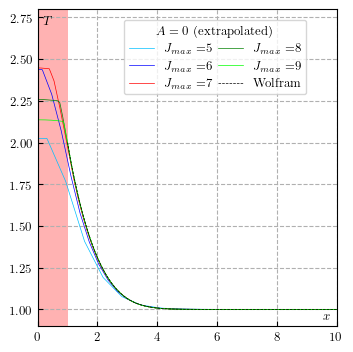

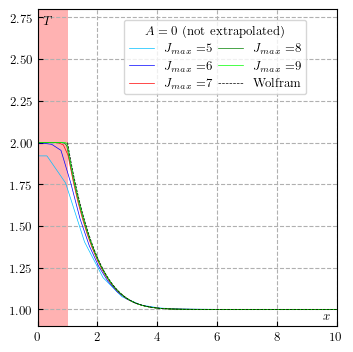

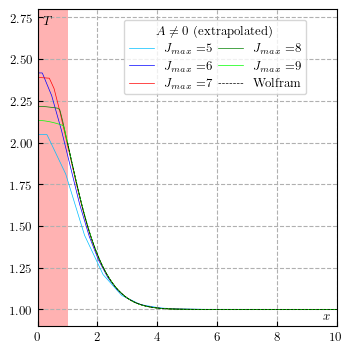

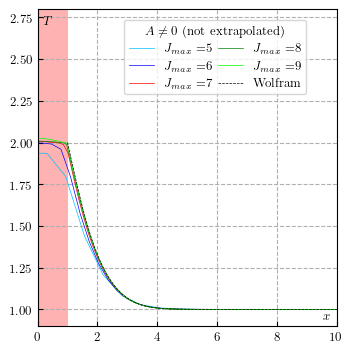

In [139]:
%matplotlib inline
rc_params: dict = {
    'font.size': 9,
    'axes.labelsize': 9,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'lines.linewidth': 0.5,
    'figure.figsize': [3.6, 3.6]
}
matplotlib.rcParams.update(rc_params)

x = None
t_fix = 0.6
field = "T_target"
linewidth = 0.5

x_fun = lambda maxlevel, name: polym(x, t_fix, maxlevel=maxlevel, field="x", name=name)
T_fun = lambda maxlevel, name: polym(x, t_fix, maxlevel=maxlevel, field="T", name=name)
T_target_fun = lambda maxlevel, name: polym(x, t_fix, maxlevel=maxlevel, field="T_target", name=name)
levels = np.arange(5,10)
colors = {5:"deepskyblue", 6: "blue", 7: "red", 8: "green", 9: "lime"}
hrnames = {"A=0": r"$A=0$ (extrapolated)", "A=0_no_extrapolation": r"$A=0$ (not extrapolated)", "Aneq0": r"$A\neq0$ (extrapolated)", "Aneq0_no_extrapolation": r"$A\neq0$ (not extrapolated)"}
for prefix in [
    "A=0", "A=0_no_extrapolation", 
    "Aneq0", "Aneq0_no_extrapolation"
]:
    
    y_new = data_theory_all[prefix].sol(t_fix)
    T_sol, alpha_sol = np.split(y_new, 2)
    r_sol, = args
    
    lines = [
        Line(
            x=x_fun(maxlevel=level, name=prefix), 
            y=T_fun(maxlevel=level, name=prefix), 
            name=r'$J_{max}=$' + str(level), 
            style='solid', 
            color=colors[level],
            linewidth=linewidth
        ) 
        for level in levels
    ]
    # lines += [
    #     Line(
    #         x=x_fun(maxlevel=level, name=prefix),
    #         y=T_target_fun(maxlevel=level, name=prefix),
    #         name=r'$J_{max}=$' + str(level) + " (target)",
    #         style='dashed',
    #         color=colors[level],
    #         # marker="o",
    #         linewidth=linewidth
    #     ) for level in levels
    # ]
    if 0:
        lines += [
            Line(
                x=x_fun(maxlevel=level, name=prefix),
                y=T_target_fun(maxlevel=level, name=prefix),
                name=r'$J_{max}=$' + str(level) + " (target)",
                style='dashed',
                color=colors[level],
                # marker="o",
                linewidth=linewidth
            ) for level in levels
        ]
    lines.append(
        Line(x=r_sol, y=T_sol, name=r'Wolfram', style='dashed', color='black', linewidth=linewidth),
    )
    
    plot_matplotlib(
        lines=lines,
        xlabel={'xlabel': r'$x$', 'horizontalalignment': 'right', 'x': 1.005, 'rotation':0},
        ylabel={'ylabel': r'$T$', 'verticalalignment': 'top', 'y': 1, 'rotation':0},
        xaxis={"set_label_coords": (0.98, 0.05)},
        yaxis={"set_label_coords": (0.03, 0.98)},
        xtick_params={"direction": 'in'},
        ytick_params={"direction": 'in'},
        xrange=[0., 10],
        yrange=[0.9, 2.8],
        #yrange=None,
        axis_visibility={},
        image_name=f"verification_polym_T_{prefix}.pdf",
        path=path,
        title=None,
        legend_props={"loc": (0.35,0.73), "ncol": 2, "columnspacing": 0.5, "title": hrnames[prefix]},
        grid={"axis":"both" },
        vertical=[0,1],
        horizontal=[0,2]
    )


Saved image ../Heat_transfer_Polymerization/Verif/output/original_verification_polym_alpha_Aneq0.pdf
GPL Ghostscript 10.03.1 (2024-05-02)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1
Saved image ../Heat_transfer_Polymerization/Verif/output/original_verification_polym_alpha_Aneq0_no_extrapolation.pdf
GPL Ghostscript 10.03.1 (2024-05-02)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1


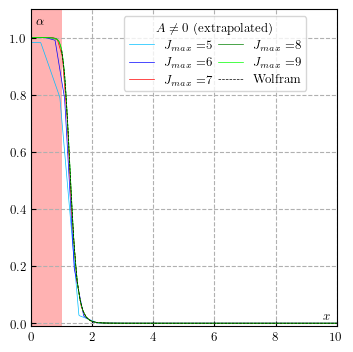

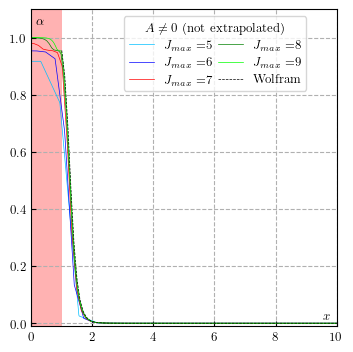

In [140]:
%matplotlib inline
rc_params: dict = {
    'font.size': 9,
    'axes.labelsize': 9,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'lines.linewidth': 0.5,
    'figure.figsize': [3.6, 3.6]
}
matplotlib.rcParams.update(rc_params)

x = None
t_fix = 1
field = "T_target"
l=6
linewidth = 0.5

x_fun = lambda maxlevel, name: polym(x, t_fix, maxlevel=maxlevel, field="x", name=name)
alpha_fun = lambda maxlevel, name: polym(x, t_fix, maxlevel=maxlevel, field="alpha", name=name)
levels = np.arange(5,10)
colors = {5:"deepskyblue", 6: "blue", 7: "red", 8: "green", 9: "lime"}
hrnames = {"A=0": r"$A=0$ (extrapolated)", "A=0_no_extrapolation": r"$A=0$ (not extrapolated)", "Aneq0": r"$A\neq0$ (extrapolated)", "Aneq0_no_extrapolation": r"$A\neq0$ (not extrapolated)"}
for prefix in [
    "Aneq0", "Aneq0_no_extrapolation"
]:
    y_new = data_theory_all[prefix].sol(t_fix)
    T_sol, alpha_sol = np.split(y_new, 2)
    r_sol, = args
    
    lines = [
        Line(
            x=x_fun(maxlevel=level, name=prefix), 
            y=alpha_fun(maxlevel=level, name=prefix), 
            name=r'$J_{max}=$' + str(level), 
            style='solid', 
            color=colors[level],
            linewidth=linewidth
        ) 
        for level in levels
    ]
    lines.append(
        Line(x=r_sol, y=alpha_sol, name=r'Wolfram', style='dashed', color='black', linewidth=linewidth),
    )
    
    plot_matplotlib(
        lines=lines,
        xlabel={'xlabel': r'$x$', 'horizontalalignment': 'right', 'x': 1.005, 'rotation':0},
        ylabel={'ylabel': r'$\alpha$', 'verticalalignment': 'top', 'y': 1, 'rotation':0},
        xaxis={"set_label_coords": (0.98, 0.05)},
        yaxis={"set_label_coords": (0.03, 0.98)},
        xtick_params={"direction": 'in'},
        ytick_params={"direction": 'in'},
        xrange=[0., 10],
        yrange=[-0.01, 1.1],
        # yrange=None,
        axis_visibility={},
        image_name=f"verification_polym_alpha_{prefix}.pdf",
        path=path,
        title=None,
        legend_props={"loc": (0.35,0.74), "ncol": 2, "columnspacing": 0.5, "title": hrnames[prefix]},
        grid={"axis":"both" },
        vertical=[0,1],
        horizontal=[0,2]
    )


Saved image ../Heat_transfer_Polymerization/Verif/output/original_verification_polym_convergence_T_A=0_A=0_no_extrapolation.pdf
GPL Ghostscript 10.03.1 (2024-05-02)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1
Saved image ../Heat_transfer_Polymerization/Verif/output/original_verification_polym_convergence_T_Aneq0_Aneq0_no_extrapolation.pdf
GPL Ghostscript 10.03.1 (2024-05-02)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1


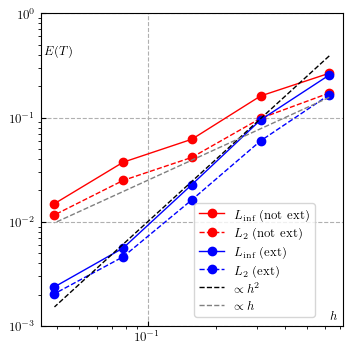

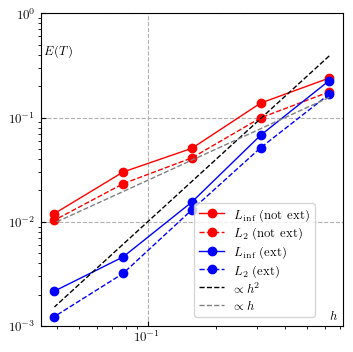

In [141]:
%matplotlib inline
rc_params: dict = {
    'font.size': 9,
    'axes.labelsize': 9,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'lines.linewidth': 0.5,
    'figure.figsize': [3.6, 3.6]
}
matplotlib.rcParams.update(rc_params)
r_fix = 1.8
t_fix = 1
field = "T"


err = lambda level, norm_type, name: compute_polym_xty_and_error(x_fix=None, t_fix=t_fix, maxlevel=level, field=field, name=name, sol=data_theory_all[name], r_sol=data_r_sol_all[name], norm_type=norm_type, kind="linear", N=1000)
err_pwe = lambda level, norm_type, name: compute_polym_xty_and_error(x_fix=r_fix, t_fix=t_fix, maxlevel=level, field=field, name=name, sol=data_theory_all[name], r_sol=data_r_sol_all[name], norm_type=norm_type, kind="linear", N=1000)

levels = np.arange(5,10)
xx = np.array([basilisk["L0"]/2**level for level in levels])

for prefix_extrapolated, prefix_not_extrapolated in [
    ("A=0", "A=0_no_extrapolation"), 
    ("Aneq0", "Aneq0_no_extrapolation")
]:
    lines = [
        Line(
            x=xx,
            y=[err(level=level, norm_type="Linf", name=prefix_not_extrapolated) for level in levels], 
            name=r'$L_{\text{inf}}$ (not ext)',
            style='solid', 
            marker="o", 
            color='red'
        ),
        Line(
            x=xx, 
            y=[err(level=level, norm_type="L2", name=prefix_not_extrapolated) for level in levels], 
            name=r'$L_{2}$ (not ext)', 
            style='dashed', 
            marker="o", 
            color='red'
        ),
        # Line(
        #     x=xx, 
        #     y=[err_pwe(level=level, norm_type="L2", name=prefix_not_extrapolated) for level in levels], 
        #     name=r'$L_{pwe}$', 
        #     style='dotted', 
        #     marker="o", 
        #     color='red'
        # ),
        Line(
            x=xx, 
            y=[err(level=level, norm_type="Linf", name=prefix_extrapolated) for level in levels], 
            name=r'$L_{\text{inf}}$ (ext)', 
            style='solid', 
            marker="o", 
            color='blue'
        ),
        Line(
            x=xx, 
            y=[err(level=level, norm_type="L2", name=prefix_extrapolated) for level in levels], 
            name=r'$L_{2}$ (ext)', 
            style='dashed', 
            marker="o", 
            color='blue'
        ),
        # Line(
        #     x=xx, 
        #     y=[err_pwe(level=level, norm_type="L2", name=prefix_extrapolated) for level in levels], 
        #     name=r'$L_{pwe}$', 
        #     style='dotted', 
        #     marker="o", 
        #     color='blue'
        # ),
        # Line(x=xx, y=yy_L_x_fix, name=rf'$E(r={r_fix})$', style='solid', marker="o", color='lime'),
        Line(x=xx, y=xx**2, name=r'$\propto h^2$', style='dashed', color='black'),
        Line(x=xx, y=0.25*xx, name=r'$\propto h$', style='dashed', color='grey'),
    ]
    
    plot_matplotlib(
        lines=lines,
        xlabel={'xlabel': r'$h$', 'horizontalalignment': 'right', 'x': 1.005, 'rotation':0},
        ylabel={'ylabel': r'$E(T)$', 'verticalalignment': 'top', 'y': 1, 'rotation':0},
        xaxis={"set_label_coords": (0.98, 0.05)},
        yaxis={"set_label_coords": (0.06, 0.9)},
        xtick_params={"direction": 'in'},
        ytick_params={"direction": 'in'},
        xrange=None,
        yrange=[1e-3, 1],
        axis_visibility={},
        image_name=f"verification_polym_convergence_T_{prefix_extrapolated}_{prefix_not_extrapolated}.pdf",
        path=path,
        title=None,
        legend_props={"loc": (0.55,0.1), "ncol": 1, "columnspacing": 0.5},
        grid={"axis":"both"},
        set_xscale={"value": "log"},
        set_yscale={"value": "log"},
    )

Saved image ../Heat_transfer_Polymerization/Verif/output/original_verification_polym_convergence_alpha_Aneq0_Aneq0_no_extrapolation.pdf
GPL Ghostscript 10.03.1 (2024-05-02)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1


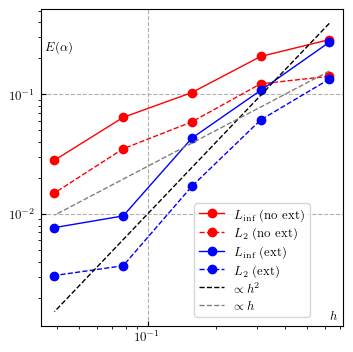

In [142]:
%matplotlib inline
rc_params: dict = {
    'font.size': 9,
    'axes.labelsize': 9,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'lines.linewidth': 0.5,
    'figure.figsize': [3.6, 3.6]
}
matplotlib.rcParams.update(rc_params)
r_fix = 1.8
t_fix = 1
field = "alpha"


err = lambda level, norm_type, name: compute_polym_xty_and_error(x_fix=None, t_fix=t_fix, maxlevel=level, field=field, name=name, sol=data_theory_all[name], r_sol=data_r_sol_all[name], norm_type=norm_type, kind="linear", N=1000)
err_pwe = lambda level, norm_type, name: compute_polym_xty_and_error(x_fix=r_fix, t_fix=t_fix, maxlevel=level, field=field, name=name, sol=data_theory_all[name], r_sol=data_r_sol_all[name], norm_type=norm_type, kind="linear", N=1000)

levels = np.arange(5,10)
xx = np.array([basilisk["L0"]/2**level for level in levels])

for prefix_extrapolated, prefix_not_extrapolated in [
    # ("A=0", "A=0_no_extrapolation"), 
    ("Aneq0", "Aneq0_no_extrapolation")
]:
    lines = [
        Line(
            x=xx,
            y=[err(level=level, norm_type="Linf", name=prefix_not_extrapolated) for level in levels], 
            name=r'$L_{\text{inf}}$ (no ext)',
            style='solid', 
            marker="o", 
            color='red'
        ),
        Line(
            x=xx, 
            y=[err(level=level, norm_type="L2", name=prefix_not_extrapolated) for level in levels], 
            name=r'$L_{2}$ (no ext)', 
            style='dashed', 
            marker="o", 
            color='red'
        ),
        # Line(
        #     x=xx, 
        #     y=[err_pwe(level=level, norm_type="L2", name=prefix_not_extrapolated) for level in levels], 
        #     name=r'$L_{pwe}$', 
        #     style='dotted', 
        #     marker="o", 
        #     color='red'
        # ),
        Line(
            x=xx, 
            y=[err(level=level, norm_type="Linf", name=prefix_extrapolated) for level in levels], 
            name=r'$L_{\text{inf}}$ (ext)', 
            style='solid', 
            marker="o", 
            color='blue'
        ),
        Line(
            x=xx, 
            y=[err(level=level, norm_type="L2", name=prefix_extrapolated) for level in levels], 
            name=r'$L_{2}$ (ext)', 
            style='dashed', 
            marker="o", 
            color='blue'
        ),
        # Line(
        #     x=xx, 
        #     y=[err_pwe(level=level, norm_type="L2", name=prefix_extrapolated) for level in levels], 
        #     name=r'$L_{pwe}$', 
        #     style='dotted', 
        #     marker="o", 
        #     color='blue'
        # ),
        # Line(x=xx, y=yy_L_x_fix, name=rf'$E(r={r_fix})$', style='solid', marker="o", color='lime'),
        Line(x=xx, y=xx**2, name=r'$\propto h^2$', style='dashed', color='black'),
        Line(x=xx, y=0.25*xx, name=r'$\propto h$', style='dashed', color='grey'),
    ]
    
    plot_matplotlib(
        lines=lines,
        xlabel={'xlabel': r'$h$', 'horizontalalignment': 'right', 'x': 1.005, 'rotation':0},
        ylabel={'ylabel': r'$E(\alpha)$', 'verticalalignment': 'top', 'y': 1, 'rotation':0},
        xaxis={"set_label_coords": (0.98, 0.05)},
        yaxis={"set_label_coords": (0.06, 0.9)},
        xtick_params={"direction": 'in'},
        ytick_params={"direction": 'in'},
        xrange=None,
        yrange=None,
        axis_visibility={},
        image_name=f"verification_polym_convergence_alpha_{prefix_extrapolated}_{prefix_not_extrapolated}.pdf",
        path=path,
        title=None,
        legend_props={"loc": (0.55,0.1), "ncol": 1, "columnspacing": 0.5},
        grid={"axis":"both"},
        set_xscale={"value": "log"},
        set_yscale={"value": "log"},
    )

In [203]:
data = data_all["A=0"]
# data[(data["t"] == 1) & (data["x"] == 0) & (data["maxlevel"] == 9)]
data[(data["x"] == 0) & (data["maxlevel"] == 9)]
# data_all["A=0"].to_csv(f'{path}/cylinder_polymerization_basilisk_A_0_local.csv', index=False)

,x,t,maxlevel,T,alpha,u,mu,T_target
204204,0.0,0.0,9,2.00000,0,0,0.000301,2.00039
205205,0.0,0.1,9,1.93965,0,0,0.000381,1.93965
206206,0.0,0.2,9,1.93995,0,0,0.000380,1.93995


In [536]:
from scipy import stats
res = stats.linregress(np.log(xx), np.log([err(level=level, norm_type="L2", name="A=0") for level in levels]))
print(res.slope)
res = stats.linregress(np.log(xx), np.log([err(level=level, norm_type="Linf", name="A=0") for level in levels]))
print(res.slope)

nan
nan


/var/folders/np/k_nycg1956x5prcpcqnb_rbm0000gn/T/ipykernel_61552/577673361.py:2: RuntimeWarning: divide by zero encountered in log
  res = stats.linregress(np.log(xx), np.log([err(level=level, norm_type="L2", name="A=0") for level in levels]))
/Users/evgeniisharaborin/basilisk/work/tube/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/var/folders/np/k_nycg1956x5prcpcqnb_rbm0000gn/T/ipykernel_61552/577673361.py:4: RuntimeWarning: divide by zero encountered in log
  res = stats.linregress(np.log(xx), np.log([err(level=level, norm_type="Linf", name="A=0") for level in levels]))


# Couette flow verifications

In [146]:
delta = 0.05;
pi = np.pi
chi_dif = 0.00885347
A = 0

L0 = 2

def Texact_two_humps(x,t): #2 humps
    res = Ts + 2*((T0 - Ts)/delta**6)* \
    sum([192 * cos(delta*n*pi) * sin((n*pi)/2) * \
         (delta*n*pi*(-15 + delta**2*n**2*pi**2)*cos(delta*n*pi) + \
         3*(5 - 2*delta**2*n**2*pi**2)*sin(delta*n*pi))/(n**7*pi**7)*sin(pi*n*(x + 0.5)) * \
         exp(-chi_dif*(pi*n)**2*t) for n in range(1, 100) ])
    return res

def uexact(x,t):
    res = 0.5 + x
    return res

def Texact_different_temperatures(x,t):
    res = T0 + (Ts - T0)*(x + 0.5) + \
    (Ts - T0)*sum([(((-1)**n + 1)/(pi*n*(1 - n**2)))*sin(pi*n*(x + 0.5)) * \
         exp(-chi_dif*(pi*n)**2*t) for n in range(2, 100) ])
    return res

data_r_sol_all.update({
    "couette_A=0": [], 
    "couette_A=0_different_T": [], 
    "couette_Aneq0": [], 
    "couette_Aneq0_different_T": []
})

data_theory_all.update({
    "couette_A=0": [], 
    "couette_A=0_different_T": [], 
    "couette_Aneq0": [], 
    "couette_Aneq0_different_T": []
})

# Couette: 2 Hump problem

In [58]:
%matplotlib inline
# Constants
props = {
    "rho": 1,
    "Cp": 1,
    "kappa": 1.00002,
    "H": 0.9428950863,
    "A": 0,
    "n": 1.2,
    "R": 8.31,
    "Ea": (7700/300)*8.31,
    "mu0": 1.60417e-07,
    "Eeta": 15.075*8.31,
    "chi": 20
}
props["mu_fun"] = lambda T, alpha: props["mu0"]*np.exp(props["Eeta"]/(props["R"]*T) + props["chi"]*alpha)

bc_ic = {
    "T0": 1,
    "alpha0": 0,
    "T_top": 500./300.,
    "T_bottom": 1,
    "dTdt_solid": 0,
    "dalphadt_solid": 0,
    "dUdt_solid": 0,
    "U_top": 1,
    "U_bottom": 0,
    "b": 0.05
}
hump_fun = lambda y, b: (1.0/b**6)*(b**2 - y**2)**3 if abs(y) < b else 0.0
T_init_fun = {
    "hump": lambda y: bc_ic["T_top"] + (bc_ic["T0"] - bc_ic["T_top"]) * (hump_fun(y - bc_ic["b"], bc_ic["b"]) + hump_fun(y + bc_ic["b"], bc_ic["b"])),
    "cos": lambda y: bc_ic["T_top"] if y > 0.5 else ( bc_ic["T_bottom"] if y < -0.5 else 0.5*(bc_ic["T_bottom"] + bc_ic["T_top"]) - 0.5*(bc_ic["T_top"] - bc_ic["T_bottom"])*np.cos(np.pi*(y + 0.5)))
}

U_init_fun = lambda y: bc_ic["U_top"] if y > 0.5 else ( bc_ic["U_bottom"] if y < -0.5 else 0.5*(bc_ic["U_bottom"] + bc_ic["U_top"]) - 0.5*(bc_ic["U_top"] - bc_ic["U_bottom"])*np.cos(np.pi*(y + 0.5)))
bc_ic["U0_fun"] = lambda r_arr: np.vectorize(U_init_fun)(r_arr)

nump = {
    "y_min": -0.5,
    "y_max": 0.5,
    "r_points": 101,
    "t_min": 0,
    "t_max": 1,
    "t_points": 101,
    "method": "LSODA"
}

basilisk = {
    "L0": 2
}

# Extract solutions
for name, A, init_type in [
    ("couette_A=0", 0, "hump"), 
    ("couette_Aneq0", 1.612e+06, "hump"), 
    ("couette_A=0_different_T", 0, "cos"), 
    ("couette_Aneq0_different_T", 1.612e+06, "cos")
]: 
    print(f"name={name}")
    props["A"] = A
    if init_type == "hump":
        bc_ic["T_bottom"] = bc_ic["T_top"]
    else:
        bc_ic["T_bottom"] = 1
    bc_ic["T0_fun"] = lambda y_arr: np.vectorize(T_init_fun[init_type])(y_arr)
    htp_couette, args = heat_transfer_polymerization_couette(nump, props, bc_ic)
    data_r_sol_all[name] = args[0]
    data_r_sol_all[name + "_no_extrapolation"] = args[0]
    data_theory_all[name] = htp_couette
    data_theory_all[name + "_no_extrapolation"] = htp_couette


name=couette_A=0
name=couette_Aneq0
name=couette_A=0_different_T
name=couette_Aneq0_different_T


/var/folders/np/k_nycg1956x5prcpcqnb_rbm0000gn/T/ipykernel_68847/1948605680.py:79: RuntimeWarning: overflow encountered in exp
  dalphadt = props["A"] * (1 - alpha)**props["n"] * np.exp(-props["Ea"] / (props["R"] * T))


Saved image ../Heat_transfer_Polymerization/Verif/output/original_verification_polym_T_couette_A=0.pdf
GPL Ghostscript 10.03.1 (2024-05-02)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1
Saved image ../Heat_transfer_Polymerization/Verif/output/original_verification_polym_T_couette_A=0_different_T.pdf
GPL Ghostscript 10.03.1 (2024-05-02)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1
Saved image ../Heat_transfer_Polymerization/Verif/output/original_verification_polym_T_couette_Aneq0.pdf
GPL Ghostscript 10.03.1 (2024-05-02)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the

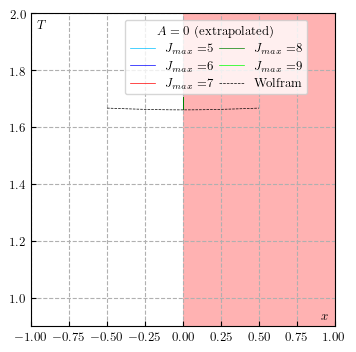

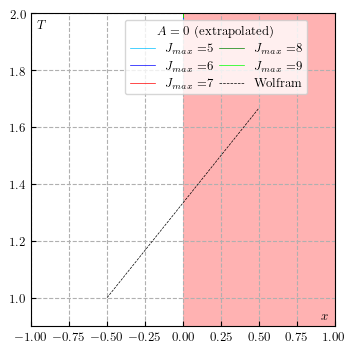

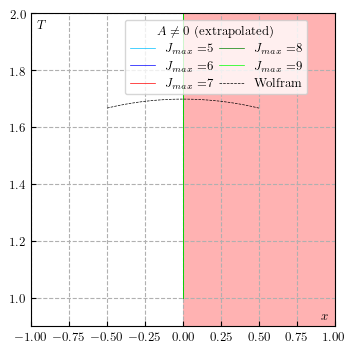

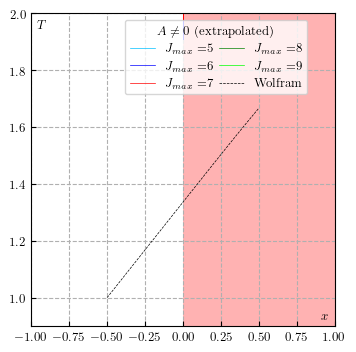

In [59]:
%matplotlib inline
rc_params: dict = {
    'font.size': 9,
    'axes.labelsize': 9,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'lines.linewidth': 0.5,
    'figure.figsize': [3.6, 3.6]
}
matplotlib.rcParams.update(rc_params)

x = None
t_fix = 0.3
field = "T_target"
linewidth = 0.5

x_fun = lambda maxlevel, name: polym(x, t_fix, maxlevel=maxlevel, field="x", name=name)
T_fun = lambda maxlevel, name: polym(x, t_fix, maxlevel=maxlevel, field="T", name=name)
T_target_fun = lambda maxlevel, name: polym(x, t_fix, maxlevel=maxlevel, field="T_target", name=name)
levels = np.arange(5,10)
colors = {5:"deepskyblue", 6: "blue", 7: "red", 8: "green", 9: "lime"}
hrnames = {"couette_A=0": r"$A=0$ (extrapolated)", "couette_A=0_different_T": r"$A=0$ (extrapolated)", "couette_Aneq0": r"$A\neq0$ (extrapolated)", "couette_Aneq0_different_T": r"$A\neq0$ (extrapolated)"}



for prefix in [
    "couette_A=0", 
    "couette_A=0_different_T", 
    "couette_Aneq0", 
    "couette_Aneq0_different_T"
]:
    
    y_new = data_theory_all[prefix].sol(t_fix)
    T_sol, alpha_sol, u_sol = np.split(y_new, 3)
    y_sol, = args
    
    lines = [
        Line(
            x=x_fun(maxlevel=level, name=prefix), 
            y=T_fun(maxlevel=level, name=prefix), 
            name=r'$J_{max}=$' + str(level), 
            style='solid', 
            color=colors[level],
            linewidth=linewidth
        ) 
        for level in levels
    ]
    # lines += [
    #     Line(
    #         x=x_fun(maxlevel=level, name=prefix),
    #         y=T_target_fun(maxlevel=level, name=prefix),
    #         name=r'$J_{max}=$' + str(level) + " (target)",
    #         style='dashed',
    #         color=colors[level],
    #         # marker="o",
    #         linewidth=linewidth
    #     ) for level in levels
    # ]
    if 0:
        lines += [
            Line(
                x=x_fun(maxlevel=level, name=prefix),
                y=T_target_fun(maxlevel=level, name=prefix),
                name=r'$J_{max}=$' + str(level) + " (target)",
                style='dashed',
                color=colors[level],
                # marker="o",
                linewidth=linewidth
            ) for level in levels
        ]
    lines.append(
        Line(x=y_sol, y=T_sol, name=r'Wolfram', style='dashed', color='black', linewidth=linewidth),
    )
    
    plot_matplotlib(
        lines=lines,
        xlabel={'xlabel': r'$x$', 'horizontalalignment': 'right', 'x': 1.005, 'rotation':0},
        ylabel={'ylabel': r'$T$', 'verticalalignment': 'top', 'y': 1, 'rotation':0},
        xaxis={"set_label_coords": (0.98, 0.05)},
        yaxis={"set_label_coords": (0.03, 0.98)},
        xtick_params={"direction": 'in'},
        ytick_params={"direction": 'in'},
        xrange=[-1, 1],
        yrange=[0.9,2],
        #yrange=None,
        axis_visibility={},
        image_name=f"verification_polym_T_{prefix}.pdf",
        path=path,
        title=None,
        legend_props={"loc": (0.35,0.73), "ncol": 2, "columnspacing": 0.5, "title": hrnames[prefix]},
        grid={"axis":"both" },
        vertical=[0,1],
        horizontal=[0,2]
    )


In [174]:
d3[(d3["maxlevel"] == 9) & (d3["t"] == 0)]["T"].values.size

1001